In [55]:
# importing needed libraries 
import numpy as np
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib_inline
from IPython import display 
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Creating the data

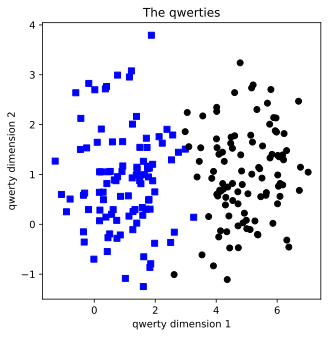

In [56]:
# create the data
nPerClust = 100
blur = 1

# center coordinates for the data cloud
A = [1, 1]
B = [5, 1]

# generating the data
a = [A[0]+np.random.randn(nPerClust)*blur, A[1]+np.random.randn(nPerClust)*blur]
b = [B[0]+np.random.randn(nPerClust)*blur, B[1]+np.random.randn(nPerClust)*blur]

# the true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatenating into the matrix 
data_np = np.hstack((a,b)).T

# converting to pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# showing the data 
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title('The qwerties')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

# Functions to build and train the model

In [57]:
def createANN(learningRate):
    # model architecture
    classifyANN = nn.Sequential(
        nn.Linear(2,1),
        nn.ReLU(),
        nn.Linear(1,1),
        # nn.Sigmoid(),
    )

    # loss function
    lossFunction = nn.BCEWithLogitsLoss() # don't need the above sigmoid since it is included in this function

    # optimizer
    optimizer = torch.optim.SGD(classifyANN.parameters(),lr=learningRate)

    # model output
    return classifyANN, lossFunction, optimizer

In [58]:
# function that trains the model
numEpochs = 1000

def TrainModel(ANN, lossFunction, optimizer):
    # initialize losses
    losses = torch.zeros(numEpochs)

    # iterate thru training
    for epoch in range(numEpochs):
        
        # forward pass
        yHat = ANN(data)

        # compute loss
        loss = lossFunction(yHat, labels)
        losses[epoch] = loss 

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # final forward pass
    predictions = ANN(data)

    # computing predictions and reporting accuracy
    totalACC = 100*torch.mean(((predictions>0) == labels).float())

    return losses,predictions,totalACC

# The Experiment

In [59]:
# the set of learning rates that we will test
learningRates = np.linspace(.001,.1,40)

# initialize results output
accuracyByLR = []
allLosses = np.zeros((len(learningRates), numEpochs))

# loop through learning rate and train
for i, lr in enumerate(learningRates):

    # creating and running the model
    classifyANN, lossFunction, optimizer = createANN(lr)
    losses, predictions, totalACC = TrainModel(classifyANN, lossFunction, optimizer)

    # storing results 
    accuracyByLR.append(totalACC)
    allLosses[i,:] = losses.detach()

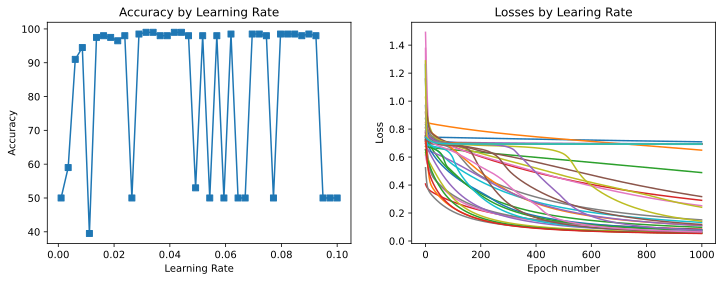

In [60]:
# plotting the results
fix,ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(learningRates,accuracyByLR,'s-')
ax[0].set_xlabel('Learning Rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy by Learning Rate')

ax[1].plot(allLosses.T)
ax[1].set_title('Losses by Learing Rate')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')
plt.show()

In [61]:
# proportion of runs where the model had at least 70% accuracy
sum(torch.tensor(accuracyByLR)>70)/len(accuracyByLR)

tensor(0.6750)

# Running a meta-experiment to get more reliable results

In [62]:
# repeating the above experiment 50 times
# then taking the average of them all 
# trying to find more meaningful relationship between accuracy and learning rate

# number of times to iterate through the experiment
numExps = 50

# matrix for storing the results
accuracyMatrix = np.zeros((numExps,len(learningRates)))

# will do less epochs for faster computation
numEpochs = 500

# the experiment
for experimentIDX in range(numExps):
    # loop through learning rate and train
    for i, lr in enumerate(learningRates):

        # creating and running the model
        classifyANN, lossFunction, optimizer = createANN(lr)
        losses, predictions, totalACC = TrainModel(classifyANN, lossFunction, optimizer)

        # storing results 
        accuracyMatrix[experimentIDX,i] = totalACC


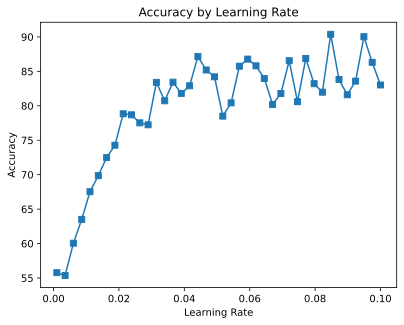

In [63]:
# plotting the results, averaged over ALL the experiments
plt.plot(learningRates,np.mean(accuracyMatrix,axis=0),'s-')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy by Learning Rate')
plt.show()